In [19]:
import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input # CRUCIAL: Import the correct preprocessing function
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os


# --- 1. SETUP AND CONFIGURATION ---

In [2]:
# Check TF Version and set mixed precision
print(f"TensorFlow version: {tf.__version__}")
mixed_precision.set_global_policy('mixed_float16')
print("Mixed precision enabled: mixed_float16")

TensorFlow version: 2.10.0
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 6GB Laptop GPU, compute capability 8.6
Mixed precision enabled: mixed_float16


In [3]:
# Global parameters
train_dir = "Train"
test_dir = "Test"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 123
NUM_CLASSES = 7 

In [4]:
# --- 2. DATASET LOADING ---

# Create Training and Validation Datasets
# Note: We load images as [0-255] for now, the preprocessing function will handle the scaling later.
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.15,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.15,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 1748 files belonging to 7 classes.
Using 1486 files for training.
Found 1748 files belonging to 7 classes.
Using 262 files for validation.
Found 697 files belonging to 7 classes.


In [5]:
class_names = train_ds.class_names
print(f"\nClass names: {class_names}")


Class names: ['Bacterial Red disease', 'Bacterial diseases - Aeromoniasis', 'Bacterial gill disease', 'Fungal diseases Saprolegniasis', 'Healthy Fish', 'Parasitic diseases', 'Viral diseases White tail disease']


In [7]:
# --- 3. DATA AUGMENTATION AND PREPROCESSING ---

# 3A. Define the Data Augmentation layer
# Use tf.keras.layers to reference the preprocessing layers already available via the tf import
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomBrightness(factor=0.1)
], name="Augmentation_Pipeline")

In [8]:
 #3b.Define the preprocessing pipeline for both augmentation and ResNet50
def apply_preprocessing_and_augmentation(image, label, augment=False):
    # 1. Apply augmentation ONLY during training
    if augment:
        image = data_augmentation(image, training=True)
    
    # 2. Apply ResNet50's specific ImageNet preprocessing (CRUCIAL STEP)
    # This transforms the images from [0, 255] to the range [-1, 1] as required by ResNet50.
    image = preprocess_input(image)
    
    return image, label

# Create the final datasets with correct preprocessing
augmented_train_ds = train_ds.map(
    lambda x, y: apply_preprocessing_and_augmentation(x, y, augment=True),
    num_parallel_calls=tf.data.AUTOTUNE
).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

val_ds = val_ds.map(
    lambda x, y: apply_preprocessing_and_augmentation(x, y, augment=False),
    num_parallel_calls=tf.data.AUTOTUNE
).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = test_ds.map(
    lambda x, y: apply_preprocessing_and_augmentation(x, y, augment=False),
    num_parallel_calls=tf.data.AUTOTUNE
).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [9]:
# --- 4. MODEL BUILDING (RESNET50) ---

# 1️⃣ Load ResNet50 base (pre-trained on ImageNet)
base_model = ResNet50(
    weights='imagenet',
    include_top=False,          
    input_shape=IMG_SIZE + (3,) 
)

# 2️⃣ Initial state: Freeze feature extractor
base_model.trainable = False

# 3️⃣ Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x) # Increased dropout for the higher capacity ResNet50
# Ensure the final layer uses float32 output for numerical stability
outputs = Dense(NUM_CLASSES, activation='softmax', dtype='float32')(x) 

model = Model(inputs=base_model.input, outputs=outputs)
print("\n--- Model Summary (Initial Frozen Phase) ---")
model.summary()



--- Model Summary (Initial Frozen Phase) ---
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                

In [10]:
# --- 5. TRAINING PHASE 1: Frozen Base (High LR) ---

# Compile model (Higher LR for new classification head)
model.compile(
    # Use a higher LR to train the new, uninitialized classification head quickly
    optimizer=Adam(learning_rate=0.001), 
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping (monitor validation accuracy)
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=10, 
    restore_best_weights=True
)

print("\n--- Starting Phase 1: Training New Head (Frozen ResNet50) ---")
history = model.fit(
    augmented_train_ds, 
    validation_data=val_ds,
    epochs=50, 
    callbacks=[early_stop]
)


--- Starting Phase 1: Training New Head (Frozen ResNet50) ---
Epoch 1/50
47/47 [==============================] - 24s 193ms/step - loss: 2.0947 - accuracy: 0.3176 - val_loss: 1.0220 - val_accuracy: 0.6450
Epoch 2/50
47/47 [==============================] - 3s 74ms/step - loss: 1.2668 - accuracy: 0.5532 - val_loss: 0.9055 - val_accuracy: 0.6565
Epoch 3/50
47/47 [==============================] - 4s 76ms/step - loss: 0.9336 - accuracy: 0.6662 - val_loss: 0.7677 - val_accuracy: 0.7137
Epoch 4/50
47/47 [==============================] - 4s 76ms/step - loss: 0.7485 - accuracy: 0.7349 - val_loss: 0.6994 - val_accuracy: 0.7366
Epoch 5/50
47/47 [==============================] - 3s 72ms/step - loss: 0.7091 - accuracy: 0.7524 - val_loss: 0.7193 - val_accuracy: 0.7290
Epoch 6/50
47/47 [==============================] - 4s 75ms/step - loss: 0.5983 - accuracy: 0.7934 - val_loss: 0.6052 - val_accuracy: 0.7939
Epoch 7/50
47/47 [==============================] - 3s 74ms/step - loss: 0.5305 - accurac

In [11]:
base_model.trainable = True

# Freeze the first 1/3 of the base model layers (to keep very generic features frozen)
num_frozen_layers = len(base_model.layers) // 3
for layer in base_model.layers[:num_frozen_layers]:
    layer.trainable = False
print(f"\n--- Fine-Tuning: Unfrozen {len(base_model.layers) - num_frozen_layers} layers of ResNet50 ---")

# 2️⃣ Recompile with a very low learning rate (essential for fine-tuning)
model.compile(
    optimizer=Adam(learning_rate=1e-5),  
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 3️⃣ Continue training (Use augmented data)
fine_tune_history = model.fit(
    augmented_train_ds, 
    validation_data=val_ds,
    epochs=20,          
    callbacks=[early_stop]
)


--- Fine-Tuning: Unfrozen 117 layers of ResNet50 ---
Epoch 1/20
47/47 [==============================] - 25s 232ms/step - loss: 0.5079 - accuracy: 0.8257 - val_loss: 0.4824 - val_accuracy: 0.8435
Epoch 2/20
47/47 [==============================] - 8s 179ms/step - loss: 0.2135 - accuracy: 0.9300 - val_loss: 0.4703 - val_accuracy: 0.8588
Epoch 3/20
47/47 [==============================] - 9s 181ms/step - loss: 0.1187 - accuracy: 0.9684 - val_loss: 0.4491 - val_accuracy: 0.8664
Epoch 4/20
47/47 [==============================] - 8s 181ms/step - loss: 0.0820 - accuracy: 0.9805 - val_loss: 0.4178 - val_accuracy: 0.8779
Epoch 5/20
47/47 [==============================] - 8s 181ms/step - loss: 0.0713 - accuracy: 0.9798 - val_loss: 0.4115 - val_accuracy: 0.8855
Epoch 6/20
47/47 [==============================] - 8s 177ms/step - loss: 0.0508 - accuracy: 0.9892 - val_loss: 0.3968 - val_accuracy: 0.8817
Epoch 7/20
47/47 [==============================] - 8s 177ms/step - loss: 0.0384 - accuracy: 

In [14]:
# --- 7. FINAL EVALUATION ---
print("\n--- Starting Final Test Evaluation ---")
loss, accuracy = model.evaluate(test_ds)
print(f"Final Test Loss: {loss:.4f}")
print(f"Final Test Accuracy: {accuracy:.4f}")
print(f"Accuracy : {accuracy*100} %")


--- Starting Final Test Evaluation ---
22/22 [==============================] - 2s 63ms/step - loss: 0.1487 - accuracy: 0.9641
Final Test Loss: 0.1487
Final Test Accuracy: 0.9641
Accuracy : 96.4132010936737 %


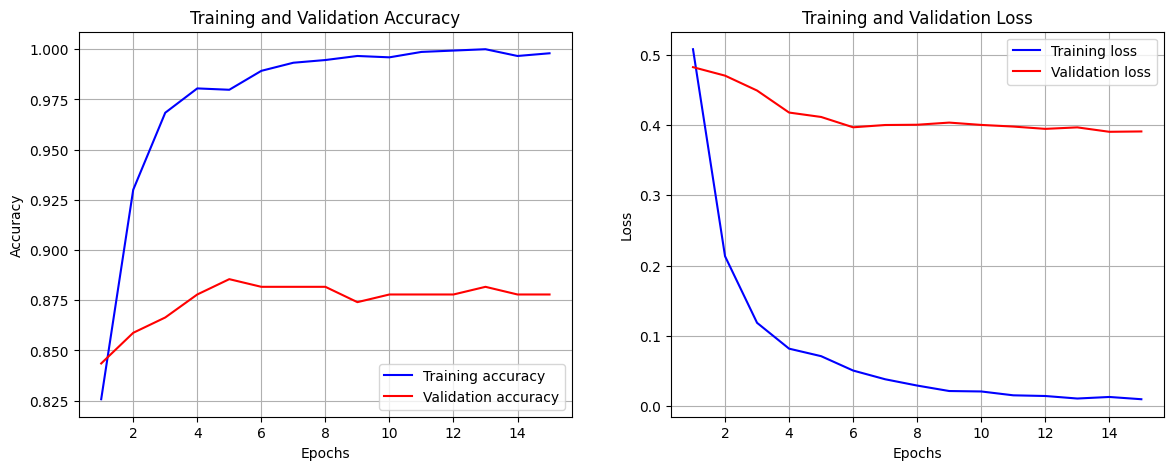

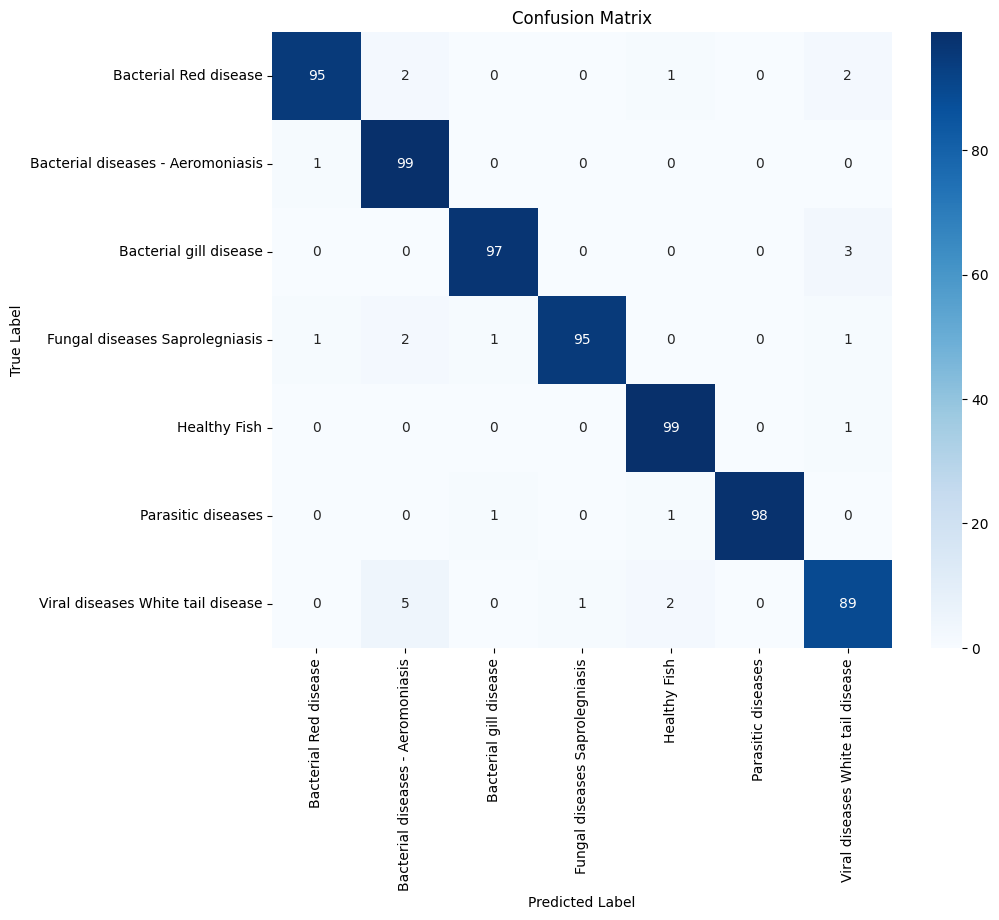


--- CLASSIFICATION REPORT ---
                                   precision    recall  f1-score   support

            Bacterial Red disease       0.98      0.95      0.96       100
Bacterial diseases - Aeromoniasis       0.92      0.99      0.95       100
           Bacterial gill disease       0.98      0.97      0.97       100
   Fungal diseases Saprolegniasis       0.99      0.95      0.97       100
                     Healthy Fish       0.96      0.99      0.98       100
               Parasitic diseases       1.00      0.98      0.99       100
Viral diseases White tail disease       0.93      0.92      0.92        97

                         accuracy                           0.96       697
                        macro avg       0.96      0.96      0.96       697
                     weighted avg       0.96      0.96      0.96       697



In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# --- 1. FUNCTION TO PLOT ACCURACY AND LOSS CURVES ---

def plot_history(history):
    """
    Plots the training and validation accuracy and loss over epochs.
    
    Args:
        history (keras.callbacks.History): The history object returned by model.fit().
    """
    
    # Check if a combined history object (from Phase 1 and Phase 2) needs to be merged
    # Since you ran two phases (initial and fine-tuning), we should check the structure.
    # Assuming 'history' is the result of the initial frozen phase and 'fine_tune_history' 
    # is the result of the second phase. If you only have one object, use that.
    
    # If both phases were run and stored separately:
    # try:
    #     acc = history.history['accuracy'] + fine_tune_history.history['accuracy']
    #     val_acc = history.history['val_accuracy'] + fine_tune_history.history['val_accuracy']
    #     loss = history.history['loss'] + fine_tune_history.history['loss']
    #     val_loss = history.history['val_loss'] + fine_tune_history.history['val_loss']
    #     epochs = range(1, len(acc) + 1)
    # except NameError: # Fallback if only one history object exists (e.g., named 'history')
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.show()

# --- 2. FUNCTION TO PLOT CONFUSION MATRIX ---

def plot_confusion_matrix(model, test_ds, class_names):
    """
    Generates and plots the confusion matrix for the test dataset.
    
    Args:
        model (tf.keras.Model): The trained classification model.
        test_ds (tf.data.Dataset): The test dataset.
        class_names (list): List of class names (strings).
    """
    
    # 1. Collect true labels and predictions from the test dataset
    true_labels = []
    predictions = []
    
    # Iterate over the test dataset to get labels and predictions
    for images, labels in test_ds:
        # Convert true labels to numpy array
        true_labels.extend(labels.numpy())
        
        # Get predictions (logits/probabilities)
        preds = model.predict(images, verbose=0)
        # Convert probabilities to class indices (the prediction)
        predictions.extend(np.argmax(preds, axis=1))

    # Convert lists to NumPy arrays
    true_labels = np.array(true_labels)
    predictions = np.array(predictions)
    
    # 2. Compute the Confusion Matrix
    cm = confusion_matrix(true_labels, predictions)
    
    # 3. Plot the Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    # 4. Print Classification Report (Precision, Recall, F1-Score)
    print("\n--- CLASSIFICATION REPORT ---")
    print(classification_report(true_labels, predictions, target_names=class_names))


# --- 3. EXECUTION BLOCKS ---

# NOTE: Execute this after running your model training script, 
# ensuring 'model', 'history' (or combined history), 'test_ds', and 'class_names' are defined.

# If you have separate history objects for Phase 1 and Phase 2:
# combined_history = tf.keras.callbacks.History()
# combined_history.history['loss'] = history.history['loss'] + fine_tune_history.history['loss']
# combined_history.history['val_loss'] = history.history['val_loss'] + fine_tune_history.history['val_loss']
# combined_history.history['accuracy'] = history.history['accuracy'] + fine_tune_history.history['accuracy']
# combined_history.history['val_accuracy'] = history.history['val_accuracy'] + fine_tune_history.history['val_accuracy']
# plot_history(combined_history)

# Assuming you named your final training history 'fine_tune_history'
if 'fine_tune_history' in locals():
    plot_history(fine_tune_history)
elif 'history' in locals():
    plot_history(history)
else:
    print("Error: Training history object (history or fine_tune_history) not found.")

# Assuming 'model', 'test_ds', and 'class_names' are available globally
try:
    plot_confusion_matrix(model, test_ds, class_names)
except NameError:
    print("Error: Model, test_ds, or class_names object not found. Ensure they are defined globally.")


In [17]:
def sample_predict(model, image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(256, 256))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    predicted_class = class_names[predicted_class_index]
    img = Image.open(image_path)
    plt.imshow(img)
    print("Predicted class:", predicted_class)

1/1 [==============================] - 3s 3s/step
Predicted class: Fungal diseases Saprolegniasis


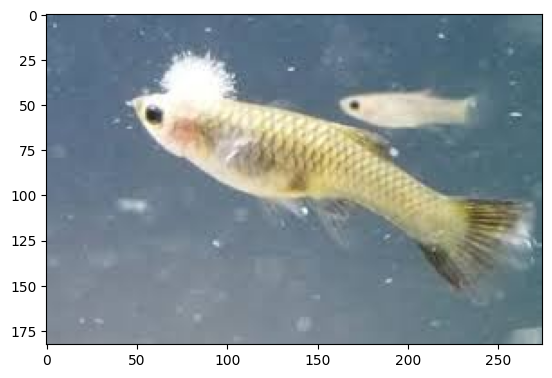

In [25]:


sample_predict(model, "C:/Users/shafe/Downloads/images (3).jpeg")